In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as L
import torch.nn.functional as F
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [2]:
from lightning_utils import *
from MOR_Operator import MOR_Operator
from POU_net import POU_net
import JHTDB_sim_op

In [3]:
dataset = JHTDB_sim_op.JHTDB_Channel('data/turbulence_output', time_chunking=1)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=16)

In [4]:
x, _ = next(iter(data_loader))
print(f'{x.shape=}')

x.shape=torch.Size([1, 3, 103, 26, 77])


In [5]:
real_channel_flow = torch.stack([x.squeeze() for x, _ in data_loader], axis=-1)

In [6]:
real_channel_flow.shape

torch.Size([3, 103, 26, 77, 4000])

In [7]:
model = JHTDB_sim_op.POU_NetSimulator.load_from_checkpoint('best_model.ckpt', n_inputs=3, n_outputs=3, ndims=3, one_cycle=True)

In [8]:
model = model.to('cuda:1')
model.simulator = model.simulator.to('cuda:1')
model.eval()
model.simulator.set_operator(super(type(model), model)) # b/c we needed to change device to cuda

In [ ]:
sim_model = model.simulator
#u0 = sim_model.genIC().detach() # random IC
u0 = real_channel_flow[..., 0].to(model.device)
with torch.no_grad():
    sim_steps = sim_model.evolve(u0, n=4001, intermediate_outputs=True, intermediate_output_stride=999).cpu()

In [11]:
u0.shape

torch.Size([3, 103, 26, 77])

In [12]:
sim_steps.shape

torch.Size([3, 103, 26, 77, 5])

In [13]:
sim_steps=sim_steps[...,:5]

##################################################
Learned Simulation:


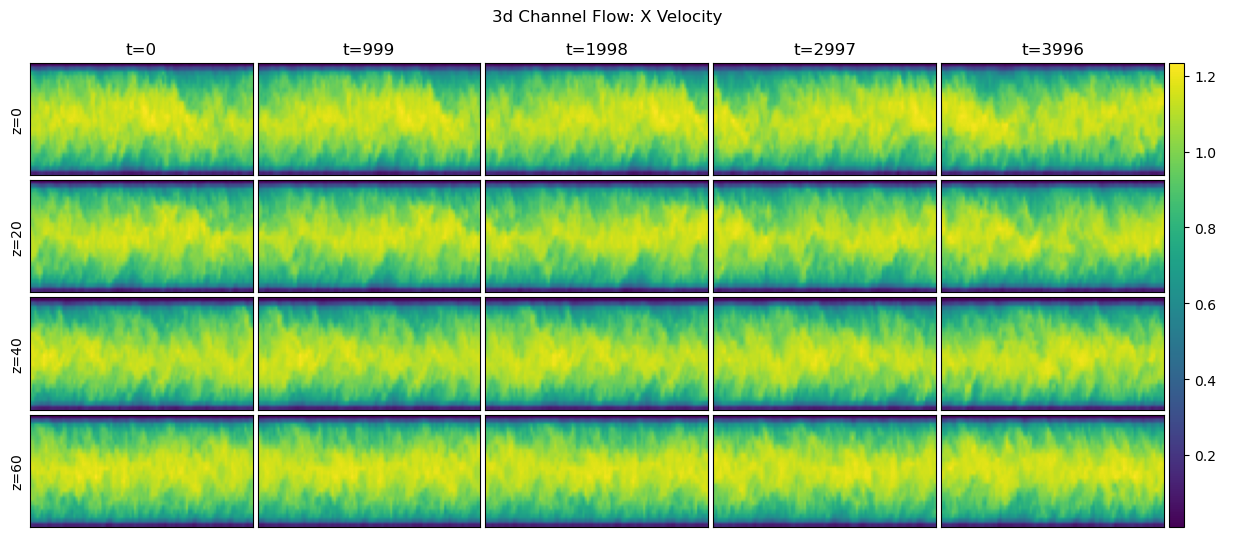

Saving GridFigure to: ./grid_figures/3d_Channel_Flow_X_Velocity.png
##################################################
DNS Simulation:


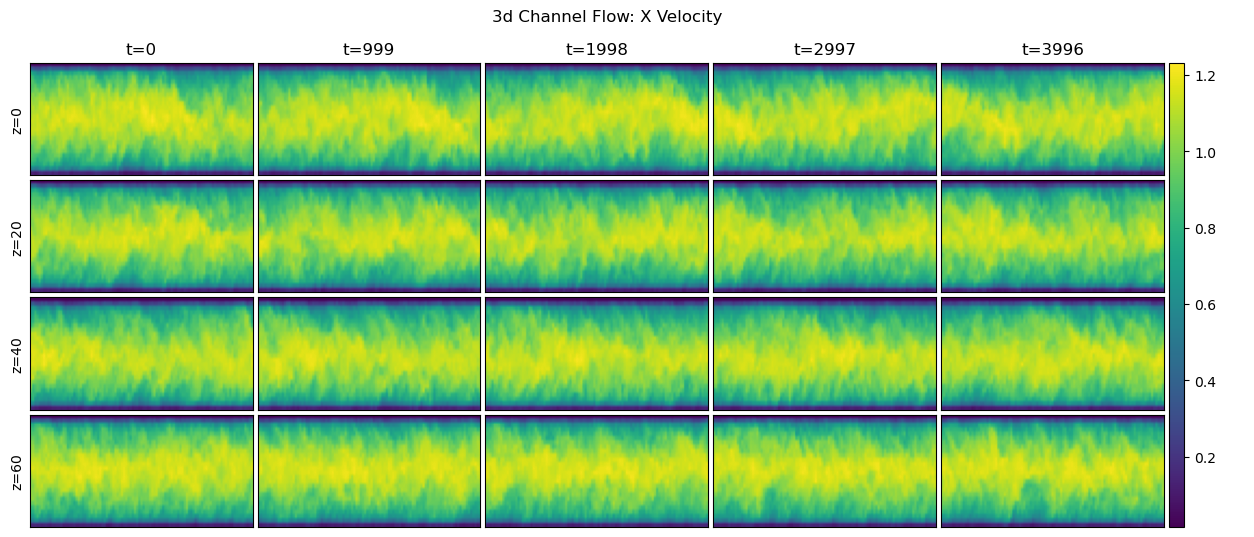

Saving GridFigure to: ./grid_figures/3d_Channel_Flow_X_Velocity.png
##################################################
Learned Simulation:


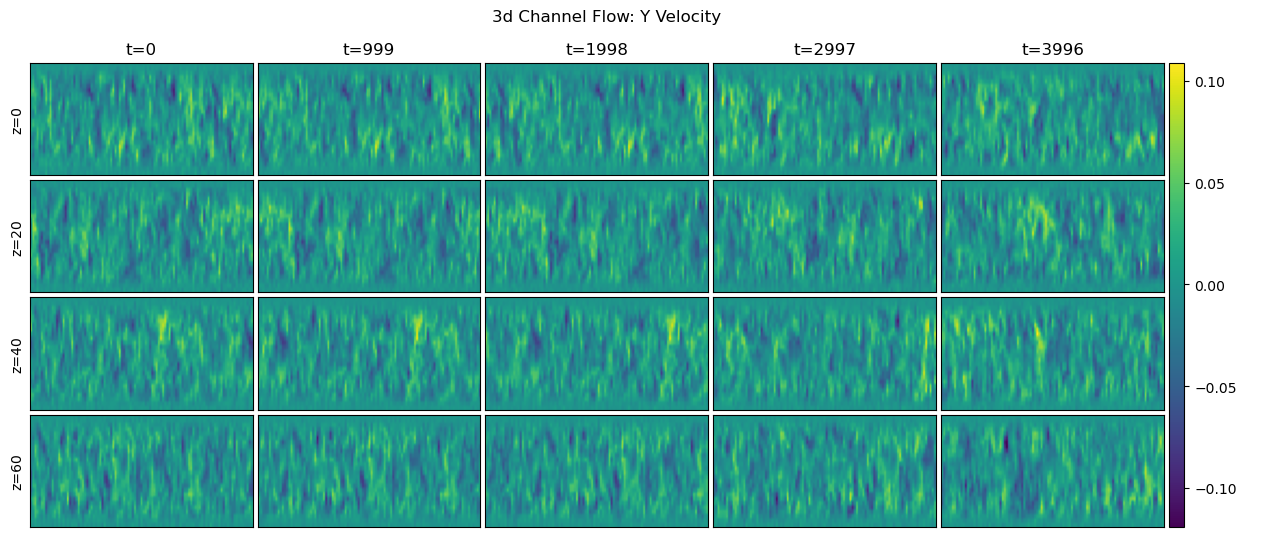

Saving GridFigure to: ./grid_figures/3d_Channel_Flow_Y_Velocity.png
##################################################
DNS Simulation:


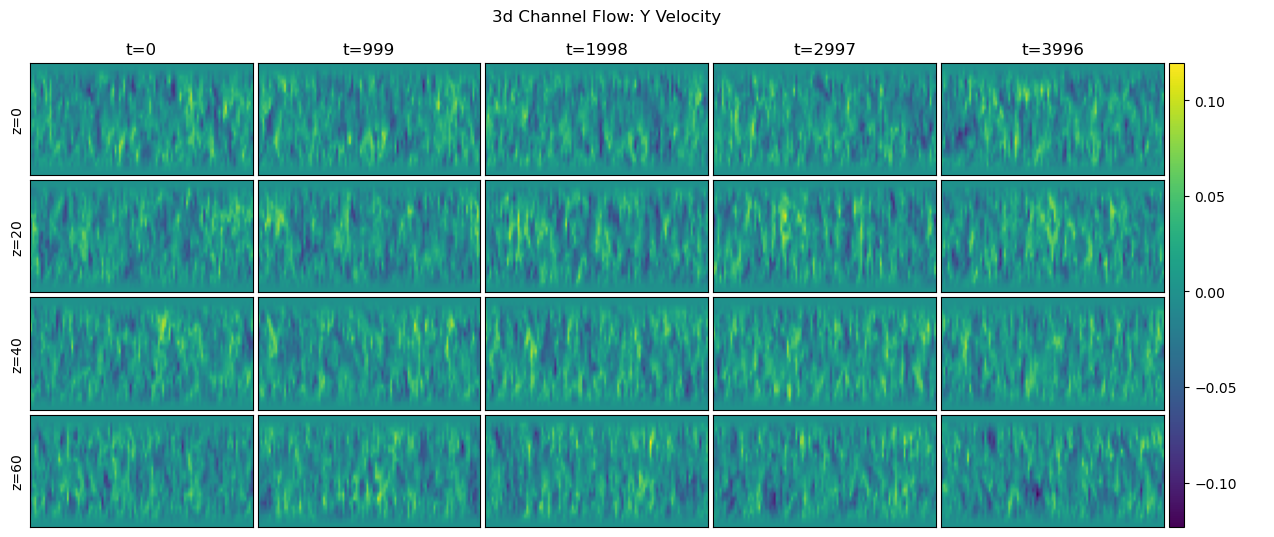

Saving GridFigure to: ./grid_figures/3d_Channel_Flow_Y_Velocity.png
##################################################
Learned Simulation:


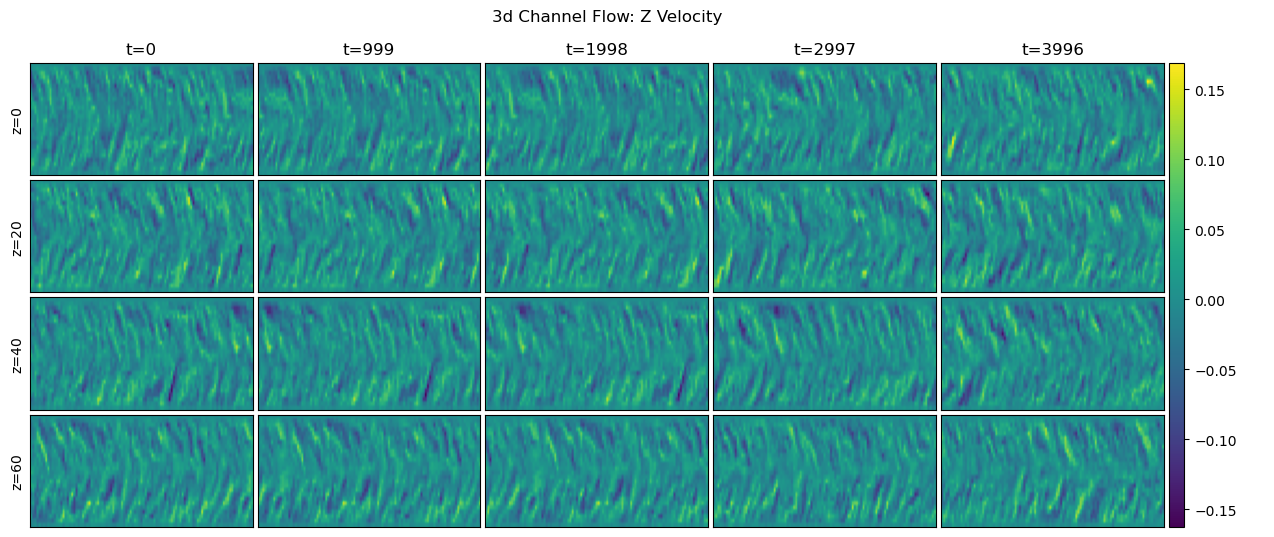

Saving GridFigure to: ./grid_figures/3d_Channel_Flow_Z_Velocity.png
##################################################
DNS Simulation:


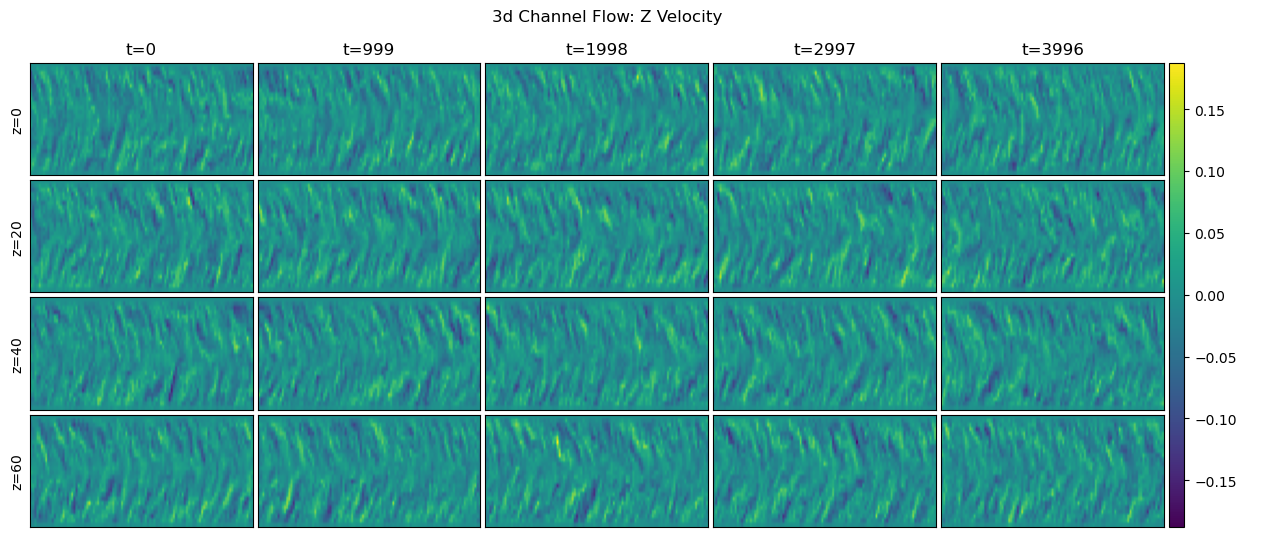

Saving GridFigure to: ./grid_figures/3d_Channel_Flow_Z_Velocity.png


In [14]:
sim_steps = sim_steps.cpu()

def make_4d_sim_fig(sim_steps, vel_comp_idx:int, time_stride=1000):
    vel_component_name = ['X','Y','Z']
    from grid_figures import GridFigure
    fig = GridFigure(f'3d Channel Flow: {vel_component_name[vel_comp_idx]} Velocity')
    for z in range(0,77,20):
        fig.add_3d_row(sim_steps[vel_comp_idx,:,:,z], f'{z=}', x_title_func=lambda t: f't={t*time_stride}',
                       img_getter=lambda array_3d, t: array_3d[:,:,t].T, time_samples=list(range(sim_steps.shape[-1])))
    fig.show()

for i in range(3):
    print('#'*50 +'\nLearned Simulation:')
    make_4d_sim_fig(sim_steps, i, time_stride=999)
    print('#'*50 +'\nDNS Simulation:')
    make_4d_sim_fig(real_channel_flow[...,::999], i, time_stride=999)